In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import warnings
import torch
import numpy as np
import chnet.cahn_hill as ch
import matplotlib.pyplot as plt
from ipywidgets import interact
from toolz.curried import pipe, curry
from pymks.bases import LegendreBasis
from pymks import MKSLocalizationModel
warnings.filterwarnings('ignore')

In [5]:
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=7)

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
def rmserror(x, y):
    return np.sqrt(np.mean((x - y)**2))

def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.95, 0.95, size=(nsamples, dim_x, dim_y))


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.1, 0.1, size=nsamples)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

## Generate Data

In [13]:
dim_x = 101
dim_y = dim_x
sim_steps = 5000 # simulation steps
dx = 0.25 # delta space_dim
dt = 0.01 # delta time
gamma = 1.0 # interface energy
device = torch.device("cuda:0")

In [19]:
%%time
nsamples = 1000 # no. of samples
init_data1 = init_unif(nsamples//2, dim_x, dim_y, seed=354875)
init_data2 = init_norm(nsamples//2, dim_x, dim_y, seed=982632)
init_data = np.concatenate([init_data1, init_data2], axis=0)
x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, dx=dx, sim_step=100, device=device)
y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, dx=dx, sim_step=sim_steps, device=device)

CPU times: user 17.2 s, sys: 18.7 s, total: 35.9 s
Wall time: 35.3 s


In [20]:
%%time
valsamples = 50
init_data1 = init_unif(valsamples//2, dim_x, dim_y, seed=938645)
init_data2 = init_norm(valsamples//2, dim_x, dim_y, seed=234580)
init_data = np.concatenate([init_data1, init_data2], axis=0)
x_val = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, dx=dx, sim_step=100, device=device)
y_val = ch.ch_run_torch(x_val, dt=dt, gamma=gamma, dx=dx, sim_step=sim_steps, device=device)

CPU times: user 1.38 s, sys: 783 ms, total: 2.17 s
Wall time: 2.17 s


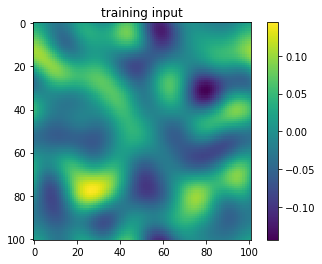

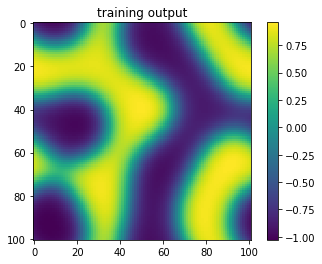

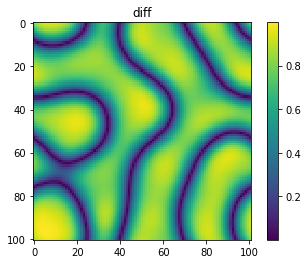

In [21]:
draw_im(x_data[0], "training input")
draw_im(y_data[0], "training output")

draw_im(np.fabs(x_data[0]-y_data[0]), "diff")

# or load saved microstructures from disk...

In [14]:
# nsamples = 1000
# x_data = np.load("data/unif/ch_5000_gamma_1000_dt_10_dx_250_101_unif.npy")[:nsamples]
# y_data = np.load("data/unif/ch_5100_gamma_1000_dt_10_dx_250_101_unif.npy")[:nsamples]

# x_val = np.load("data/unif/ch_5000_gamma_1000_dt_10_dx_250_101_unif.npy")[-nsamples:]
# y_val = np.load("data/unif/ch_5100_gamma_1000_dt_10_dx_250_101_unif.npy")[-nsamples:]

In [22]:
n_states = 11
domain = (-1.1, 1.1)
basis = LegendreBasis(n_states, domain)
model = MKSLocalizationModel(basis)

In [23]:
%%time
model.fit(x_data, y_data)

CPU times: user 26.8 s, sys: 5.12 s, total: 31.9 s
Wall time: 9.82 s


In [24]:
%%time
y_train_pred = model.predict(x_data)

CPU times: user 20.7 s, sys: 5.4 s, total: 26.1 s
Wall time: 8.75 s


In [25]:
print(rmserror(y_train_pred, y_data))
print(rmserror(y_train_pred, x_data))

0.4053376380416495
0.5232083422206159


0.4226423790580638
0.5116775513960499


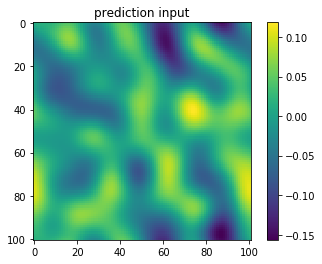

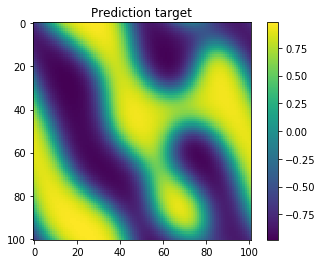

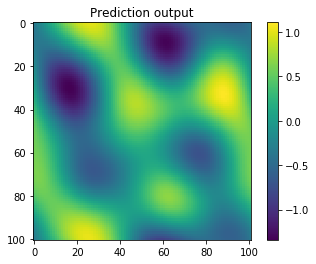

CPU times: user 2.69 s, sys: 428 ms, total: 3.12 s
Wall time: 1 s


In [34]:
%%time
y_pred = model.predict(x_val)

print(rmserror(y_pred, y_val))
print(rmserror(y_pred, x_val))

draw_im(x_val[0], "prediction input")
draw_im(y_val[0], "Prediction target")
draw_im(y_pred[0], "Prediction output")

# If we 

In [29]:
coeff = model.coef_
@interact
def draw(i = (0,n_states-1)):
#     plt.imshow(cropper(coeff[:,:,i]))
    plt.imshow(coeff[:,:,i])
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=5, description='i', max=10), Output()), _dom_classes=('widget-interact',…

In [19]:
# coeff500 = coeff.copy()
# coeff5000 = coeff.copy()
# coeff8000 = coeff.copy()

In [20]:
# for i in range(n_states):
#     print(i, rmserror(coeff5000[...,i], coeff8000[...,i]))

## Predicting future timesteps using same kernels

In [23]:
%%time
steps = 10
y_pred = x_val.copy()
print(0, y_pred.shape, rmserror(y_pred, y_val))
for step in range(steps):
    try:
        y_pred = model.predict(y_pred)
        print(step+1, y_pred.shape, rmserror(y_pred, y_val))
    except Exception as err:
        print(step, err)
        break

0 (1000, 101, 101) 0.016834531263357332
1 (1000, 101, 101) 0.00060092649020681
2 (1000, 101, 101) 0.016248064111522652
3 (1000, 101, 101) 0.03943397622210793
3 X must be within the specified domain
CPU times: user 4min 25s, sys: 26.6 s, total: 4min 52s
Wall time: 22.7 s
